In [1]:
# ATTENTION: Please do not alter any of the provided code in the exercise. Only add your own code where indicated
# ATTENTION: Please do not add or remove any cells in the exercise. The grader will check specific cells based on the cell position.
# ATTENTION: Please use the provided epoch values when training.

%matplotlib inline
import tensorflow as tf
from os import getcwd
print(tf.__version__)

2.0.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
path_daily_min_temperatures = f"{getcwd()}/../tmp2/daily-min-temperatures.csv"

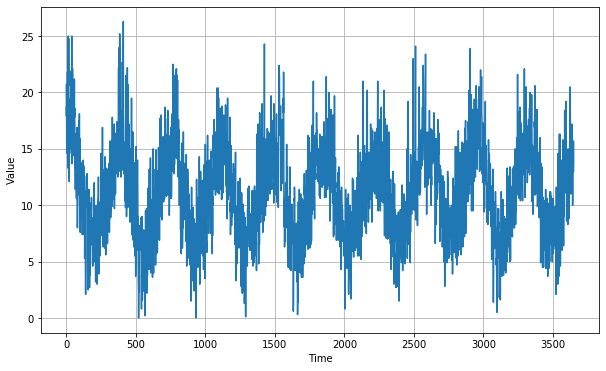

In [4]:
import csv

time_step = []
temps = []

with open(path_daily_min_temperatures) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
    # YOUR CODE HERE

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast
    # YOUR CODE HERE

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, 
                           strides=1, padding="causal",
                          activation="relu",
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
# YOUR CODE HERE
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 10s 1s/step - loss: 31.1549 - mae: 31.6551
Epoch 2/100
10/10 [==============================] - 1s 149ms/step - loss: 30.5753 - mae: 31.0783
Epoch 3/100
10/10 [==============================] - 2s 170ms/step - loss: 29.7469 - mae: 30.1792
Epoch 4/100
10/10 [==============================] - 2s 170ms/step - loss: 28.5816 - mae: 29.0582
Epoch 5/100
10/10 [==============================] - 2s 190ms/step - loss: 27.1349 - mae: 27.6970
Epoch 6/100
10/10 [==============================] - 2s 168ms/step - loss: 25.5287 - mae: 25.9975
Epoch 7/100
10/10 [==============================] - 2s 161ms/step - loss: 23.3412 - mae: 23.8407
Epoch 8/100
10/10 [==============================] - 2s 199ms/step - loss: 20.6980 - mae: 21.1120
Epoch 9/100
10/10 [==============================] - 2s 151ms/step - loss: 17.4437 - mae: 17.8083
Epoch 10/100
10/10

[1e-08, 0.0001, 0, 60]

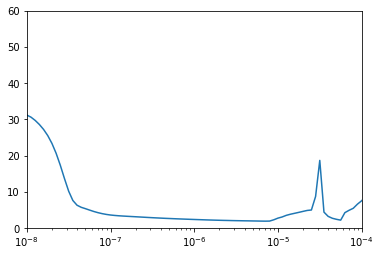

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=[None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
# YOUR CODE HERE
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9) # YOUR CODE HERE, momentum=0.9
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)  # YOUR CODE HERE
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 8s 319ms/step - loss: 9.9623 - mae: 10.5788
Epoch 2/150
25/25 [==============================] - 2s 83ms/step - loss: 2.5936 - mae: 3.0496
Epoch 3/150
25/25 [==============================] - 2s 81ms/step - loss: 1.9328 - mae: 2.3879
Epoch 4/150
25/25 [==============================] - 2s 83ms/step - loss: 1.8620 - mae: 2.3160
Epoch 5/150
25/25 [==============================] - 2s 76ms/step - loss: 1.8200 - mae: 2.2715
Epoch 6/150
25/25 [==============================] - 2s 69ms/step - loss: 1.7917 - mae: 2.2419
Epoch 7/150
25/25 [==============================] - 2s 75ms/step - loss: 1.7631 - mae: 2.2129
Epoch 8/150
25/25 [==============================] - 2s 68ms/step - loss: 1.7459 - mae: 2.1938
Epoch 9/150
25/25 [==============================] - 2s 68ms/step - loss: 1.7219 - mae: 2.1687
Epoch 10/150
25/25 [==============================] - 2s 65ms/step - loss: 1.7014 - mae: 2.1483
Epoch 11/150
25/25 [===========================

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

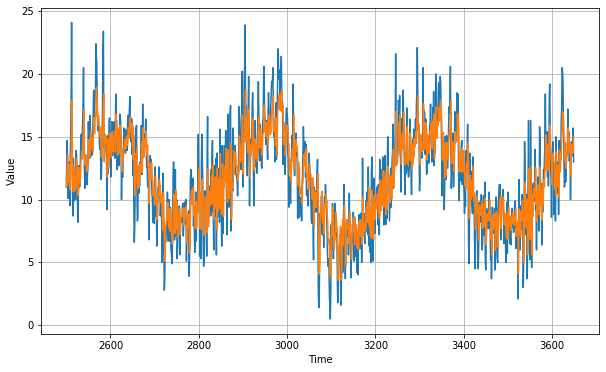

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.7814054

In [15]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.664608 11.049546 12.2731   ... 13.67045  13.804352 15.022999]


In [16]:
# Now click the 'Submit Assignment' button above.
# Once that is complete, please run the following two cells to save your work and close the notebook

In [ ]:
%%javascript
<!-- Save the notebook -->
IPython.notebook.save_checkpoint();

In [ ]:
%%javascript
IPython.notebook.session.delete();
window.onbeforeunload = null
setTimeout(function() { window.close(); }, 1000);